In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import random
import math
from tqdm import tqdm


In [13]:
from mpl_toolkits.mplot3d import Axes3D

# Layer and models

In [153]:
class LinearODELayer(nn.Module):
    def __init__(self, in_features, out_features, bias=False):
        super(LinearODELayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(self.out_features, self.in_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
    # the forward step
    def forward(self, x):
        output = x.mm(self.weight)
        if self.bias is not None:
            output += self.bias
        return output
    # the backward function is not necessary, sincewe have only used
    # functions from pytorch (in particular, .reshape and .mm)
    
    # this function is inherited from the pytorch class Linear
    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)
            
#Thsi object can be extended
class NonLinearODELayer(nn.Module):
    def __init__(self, in_dim):
        super(NonLinearODELayer, self).__init__()
        self.in_dim = in_dim
        self.weight0 = nn.Parameter(torch.Tensor(self.in_dim, self.in_dim))
        self.weight1 = nn.Parameter(torch.Tensor(self.in_dim, self.in_dim))
        self.weight2 = nn.Parameter(torch.Tensor(self.in_dim, self.in_dim))
        
    def forward(self, x):
        T = x.size(0)
        q0 = torch.diagonal(x.matmul(self.weight0.matmul(x.t()))).view(T,1)
        q1 = torch.diagonal(x.matmul(self.weight1.matmul(x.t()))).view(T,1)
        q2 = torch.diagonal(x.matmul(self.weight2.matmul(x.t()))).view(T,1)
        out = torch.cat((q0, q1, q2), dim=1)
        return out
    
    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.srqt(9))
        
class LinearODEModel(nn.Module):
    def __init__(self, in_feature, out_feature, bias=False):
        super(LinearODEModel, self).__init__()
        self.in_feature = in_feature
        self.out_feature = out_feature
        self.bias = bias
        self.ode = LinearODELayer(self.in_feature, self.out_feature, self.bias)
        
    def forward(self, x):
        out = self.ode(x)
        return out
    
    
class NNODEModel(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super(NNODEModel, self).__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        
        self.lin_ode = LinearODELayer(self.in_dim, self.out_dim)
        self.nl_ode = NonLinearODELayer(self.in_dim)
        
    def forward(self, x):
        out = self.lin_ode(x) + self.nl_ode(x)
        return out

# Training Pendulum with Linear ODE Model

In [108]:
kk = 0.01
AA = np.asarray([[1,1],[-kk,1]])

sol = [[0.99,1]]
for i in range(100):
    sol.append(np.dot(np.asarray(sol[-1]),AA))
    
X = np.asarray(sol)[:-1]
Y = np.asarray(sol)[1:]
train_x = torch.FloatTensor(X)
train_y = torch.FloatTensor(Y)

print('train_x.shape:', train_x.shape)#train_input
print('train_y.shape:', train_y.shape)#train_output

train_x.shape: torch.Size([100, 2])
train_y.shape: torch.Size([100, 2])


Real weigths of the matrix:
[[ 1.    1.  ]
 [-0.01  1.  ]]
Initial weigths of the matrix:
[Parameter containing:
tensor([[ 0.4557,  0.6042],
        [-0.6894,  0.4489]], requires_grad=True)]
Final weigths of the matrix:
[Parameter containing:
tensor([[ 0.9977,  0.9983],
        [-0.0100,  1.0000]], requires_grad=True)]


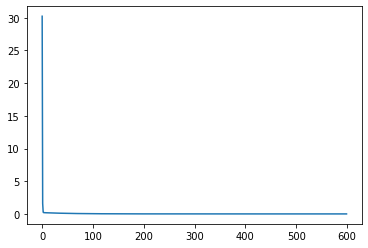

In [7]:
model = LinearODEModel(2, 2)
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
print('Real weigths of the matrix:')
print(AA)
print('Initial weigths of the matrix:')
print(list(model.parameters()))

train_loss = []

for epoch in range(600):  # number of epochs
    # Step 1. Remember that Pytorch accumulates gradients.
    # We need to clear them out before each instance
    model.zero_grad()

    # Step 2. Run our forward pass.
    prediction = model(train_x) #minibatches of size 1: to be modified
    # Step 3. Compute the loss, gradients, and update the parameters by
    #  calling optimizer.step()
    loss = loss_fn(prediction, train_y)
    train_loss.append(loss)
    loss.backward()
    optimizer.step()
    
print('Final weigths of the matrix:')
print(list(model.parameters()))
plt.plot(train_loss)
plt.show()

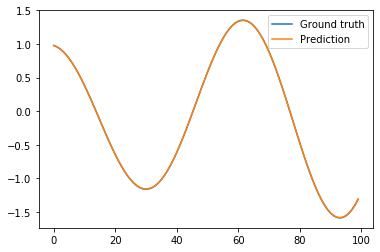

In [12]:
plt.plot(train_y[:,0].numpy(), label='Ground truth')
plt.plot(prediction[:,0].detach().numpy(), label='Prediction')
plt.legend()
plt.show()

# Training pendulum with bias

Real weigths of the matrix:
[[ 1.    1.  ]
 [-0.01  1.  ]]
Initial weigths of the matrix:
[Parameter containing:
tensor([[-0.6144,  0.5536],
        [ 0.1536, -0.4627]], requires_grad=True), Parameter containing:
tensor([-0.5922,  0.0529], requires_grad=True)]
Final weigths of the matrix:
[Parameter containing:
tensor([[ 0.9899,  0.9979],
        [-0.0098,  1.0000]], requires_grad=True), Parameter containing:
tensor([-0.0072, -0.0008], requires_grad=True)]


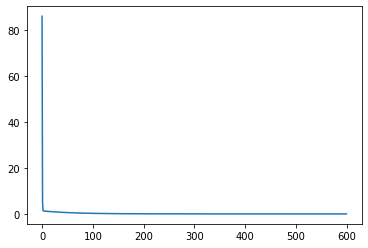

In [109]:
#with bias
model = LinearODEModel(2, 2, True)
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
print('Real weigths of the matrix:')
print(AA)
print('Initial weigths of the matrix:')
print(list(model.parameters()))

train_loss = []

for epoch in range(600):  # number of epochs
    # Step 1. Remember that Pytorch accumulates gradients.
    # We need to clear them out before each instance
    model.zero_grad()

    # Step 2. Run our forward pass.
    prediction = model(train_x) #minibatches of size 1: to be modified
    # Step 3. Compute the loss, gradients, and update the parameters by
    #  calling optimizer.step()
    loss = loss_fn(prediction, train_y)
    train_loss.append(loss)
    loss.backward()
    optimizer.step()
    
print('Final weigths of the matrix:')
print(list(model.parameters()))
plt.plot(train_loss)
plt.show()

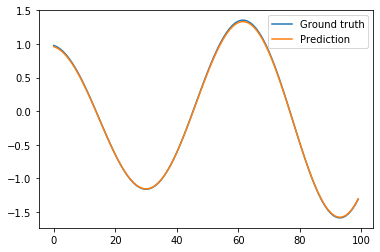

In [110]:
plt.plot(train_y[:,0].numpy(), label='Ground truth')
plt.plot(prediction[:,0].detach().numpy(), label='Prediction')
plt.legend()
plt.show()

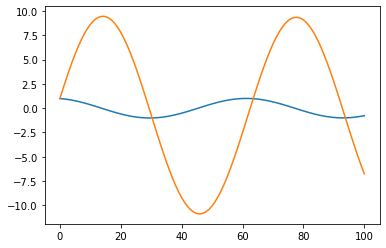

In [128]:
Atest = np.asarray([[0.9899,0.9979],[-0.0098,1.0000]])
btest = np.asarray([-0.0072, -0.0008])

soltest = [[0.99,1]]

for i in range(100):
    soltest.append(np.dot(np.asarray(soltest[-1]),Atest) + btest)
    
Xtest = np.asarray(soltest)
plt.plot(Xtest)
plt.show()

# Training Lorenz attractor with Non Linear ODE model

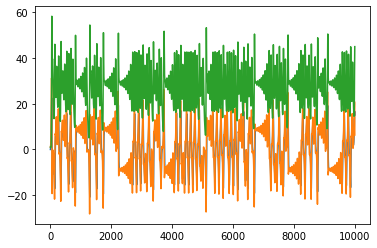

In [39]:
x = 0
y = 1
z = 1.05
sigma = 10
rho = 30
beta = 8/3
dt = 0.01

sol = [[x, y, z]]
for i in range(10000):
    f = x + (sigma*(y - x))*dt
    g = y + (rho*x - x*z - y)*dt
    h = z + (x*y - beta*z)*dt
    sol.append([f,g,h])
    x = f
    y = g
    z = h


plt.plot(sol)
plt.show()

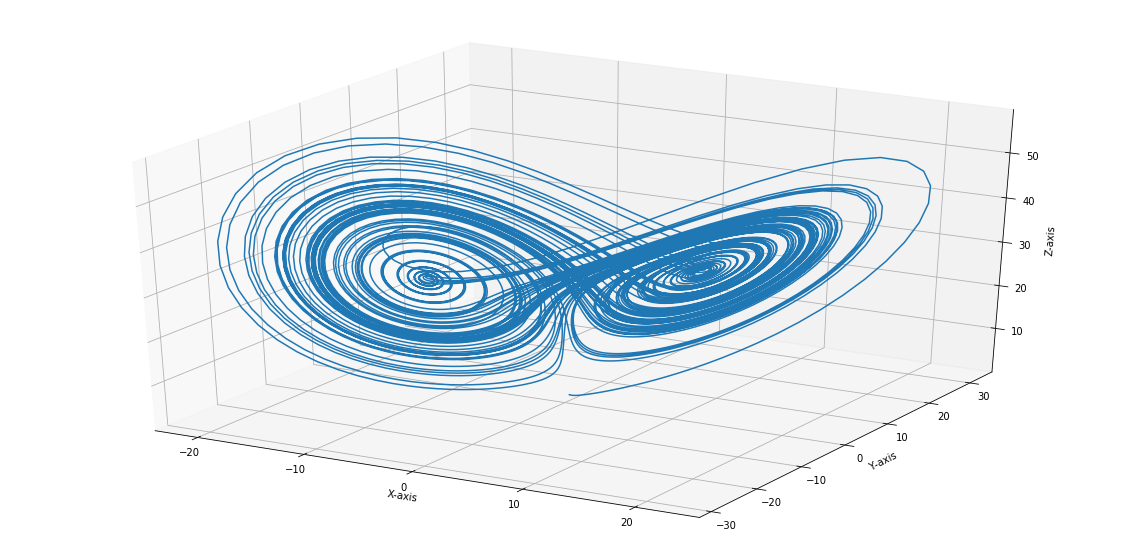

In [57]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d')
ax.plot(np.array(sol)[:,0], np.array(sol)[:,1], np.array(sol)[:,2])
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
plt.show()

In [71]:
sigma = 10
rho = 28
beta = 8/3

dt = 0.01

A = np.asarray([[-sigma, sigma, 0], [rho, -1, 0], [0, 0, -beta]])
Q0 = np.asarray([[0,0,0], [0,0,0], [0,0,0]])
Q1= np.asarray([[0,0,-1], [0,0,0], [0,0,0]])
Q2 = np.asarray([[0,1,0],[0,0,0], [0,0,0]])


sol = [[ 0., 1., 1.05]]

for i in range(10000):
    x = np.asarray(sol[-1])
    Ax = A.dot(x)
    
    q0 = x.T.dot(Q0.dot(x))
    q1 = x.T.dot(Q1.dot(x))
    q2 = x.T.dot(Q2.dot(x))

    phix = np.asarray([q0, q1, q2])
    
    f = Ax + phix
    x = x + dt*f
    sol.append(x)
    
X = np.asarray(sol)[:-1]
Y = np.asarray(sol)[1:]
train_x = torch.FloatTensor(X)
train_y = torch.FloatTensor(Y)

print('train_x.shape:', train_x.shape)#train_input
print('train_y.shape:', train_y.shape)#train_output

train_x.shape: torch.Size([10000, 3])
train_y.shape: torch.Size([10000, 3])


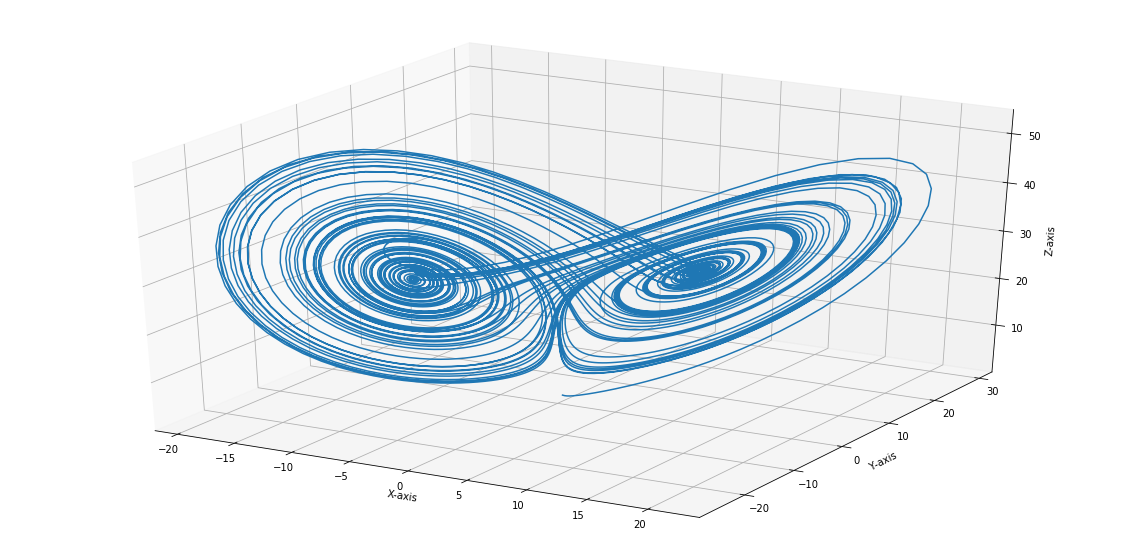

In [72]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d')
ax.plot(X[:,0], X[:,1], X[:,2])
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
plt.show()

Real weigths of the matrix:
[[-10.          10.           0.        ]
 [ 28.          -1.           0.        ]
 [  0.           0.          -2.66666667]]
tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], requires_grad=True)
tensor([[ 0.,  0., -1.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]], requires_grad=True)
tensor([[0., 1., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], requires_grad=True)
Initial weigths of the matrix:
[Parameter containing:
tensor([[-0.0219, -0.1055, -0.2025],
        [-0.1833, -0.5646,  0.3489],
        [ 0.2090, -0.2400, -0.1802]], requires_grad=True), Parameter containing:
tensor([[0.0000e+00, 3.6893e+19, 1.1010e-09],
        [3.6902e+19, 9.8091e-45, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00]], requires_grad=True), Parameter containing:
tensor([[0.0000e+00, 0.0000e+00, 6.5623e-10],
        [1.3235e-08, 1.0991e-05, 6.8317e-07],
        [2.6854e-06, 2.1887e+23, 2.6586e+23]], requires_grad=True), Parameter containing:
te

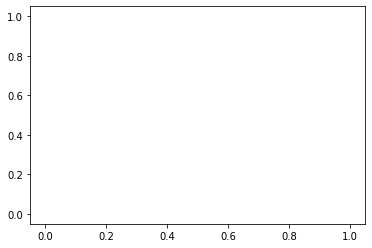

In [155]:
#Training
model = NNODEModel(3,3,3)

loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
print('Real weigths of the matrix:')
print(A)
print(Q0)
print(Q1)
print(Q2)
print('Initial weigths of the matrix:')
print(list(model.parameters()))

train_loss = []

for epoch in range(600):  # number of epochs
    # Step 1. Remember that Pytorch accumulates gradients.
    # We need to clear them out before each instance
    model.zero_grad()

    # Step 2. Run our forward pass.
    prediction = model(train_x) #minibatches of size 1: to be modified
    # Step 3. Compute the loss, gradients, and update the parameters by
    #  calling optimizer.step()
    loss = loss_fn(prediction, train_y)
    train_loss.append(loss)
    loss.backward()
    optimizer.step()
    
    
print('Final weigths of the matrix:')
print(list(model.parameters()))
plt.plot(train_loss)
plt.show()

In [115]:
#Pytorch test
Q0 = torch.Tensor([[0,0,0], [0,0,0], [0,0,0]]).requires_grad_(True)
Q1 = torch.Tensor([[0,0,-1], [0,0,0], [0,0,0]]).requires_grad_(True)
Q2 = torch.Tensor([[0,1,0],[0,0,0], [0,0,0]]).requires_grad_(True)

x = torch.randn(100, 3)

q0 = torch.diagonal(x.matmul(Q0.matmul(x.t()))).view(100,1)
q1 = torch.diagonal(x.matmul(Q1.matmul(x.t()))).view(100,1)
q2 = torch.diagonal(x.matmul(Q2.matmul(x.t()))).view(100,1)


In [116]:
q0.shape

torch.Size([100, 1])

In [156]:
phix = torch.cat((q0, q1, q2), dim=1)
phix

tensor([[ 0.0000e+00,  7.0213e-01,  8.9253e-01],
        [ 0.0000e+00,  2.6954e-01, -2.3279e+00],
        [ 0.0000e+00,  9.5630e-02,  6.3677e-02],
        [ 0.0000e+00,  1.6915e-01, -2.0753e-01],
        [ 0.0000e+00,  1.4025e-01, -1.6052e-01],
        [ 0.0000e+00,  8.4111e-01, -9.0792e-01],
        [ 0.0000e+00,  1.7585e+00,  1.1648e+00],
        [ 0.0000e+00, -1.3962e-01, -6.8695e-01],
        [ 0.0000e+00, -1.9270e-01,  5.2607e-01],
        [ 0.0000e+00,  4.5374e-02,  4.4979e-03],
        [ 0.0000e+00,  5.4936e-01,  2.0221e+00],
        [ 0.0000e+00,  4.7789e-02, -8.5264e-02],
        [ 0.0000e+00, -1.2419e+00, -2.3116e-01],
        [ 0.0000e+00, -2.4699e+00,  5.1584e-01],
        [ 0.0000e+00, -1.2356e+00,  5.8893e-01],
        [ 0.0000e+00, -7.6456e-01, -1.0409e+00],
        [ 0.0000e+00, -1.0741e+00,  1.5564e-01],
        [ 0.0000e+00, -1.0983e+00, -7.2341e-01],
        [ 0.0000e+00, -7.2432e-01, -6.5986e-02],
        [ 0.0000e+00,  1.2349e-01,  1.2104e-01],
        [ 0.0000e+00

In [146]:
x = torch.arange(6).view(2,3)
